# Making big cat states using even-parity projectors

Author: Guillaume Thekkadath

In this tutorial, we numerically simulate the protocol proposed in [arXiv:1908.10314](https://arxiv.org/abs/1908.10314) for engineering superpositions of coherent states. We study how to make big cat states $|\text{cat}\rangle \sim |\alpha \rangle + |-\alpha \rangle$ with $|\alpha|^2 = 10$.

In [1]:
import numpy as np
from qutip import wigner, Qobj, wigner_cmap

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import strawberryfields as sf
from strawberryfields.ops import *
from thewalrus.quantum import state_vector, density_matrix

## Ideal preparation

Here we setup some basic parameters, like the value of the photon-number-resolving detectors we will use to herald and the parameters of the different Gaussian unitaries.

In [2]:
Lambda = 0.9 # Lambda is a squeezing parameter in [0,1)
r = np.arctanh(Lambda)
catSize = 10 # One obtains a better fidelity when this number is an integer (see paper for explanation)
alpha = np.sqrt(catSize)*Lambda # Coherent state amplitude is chosen to compensate finite squeezing, Lambda < 1
detOutcome = int(round(catSize))
m0 = detOutcome
m1 = detOutcome
print(m0,m1)

10 10


Now we setup a 3-mode quantum circuit in Strawberry Fields and obtain the covariance matrix and vector of means of the Gaussian state.

In [3]:
nmodes = 3
prog = sf.Program(nmodes)
eng = sf.Engine("gaussian")
with prog.context as q:
    S2gate(r)             | (q[1],q[2])
    Dgate(1j*alpha)       | q[0]
    BSgate()              | (q[0],q[1])
state = eng.run(prog).state
mu = state.means()
cov = state.cov()

In [4]:
# Here we use the sf circuit drawer and standard linux utilities 
# to generate an svg representing the circuit
file, _ = prog.draw_circuit()
filepdf = file[0:-3]+"pdf"
filepdf = filepdf.replace("circuit_tex/","")
filecrop = filepdf.replace(".pdf","-crop.pdf")
name = "cat_circuit.svg"
!pdflatex  $file > /dev/null 2>&1
!pdfcrop $filepdf > /dev/null 2>&1
!pdf2svg $filecrop $name

Here is a graphical representation of the circuit. It is always assumed that the input is vacuum in all the modes. <br>
![img](./cat_circuit.svg)

We can now inspect the covariance matrix and vector of means. Note that the vector of means is non-zero since we used a displacement gate.

In [5]:
print(np.round(mu,10))
print(np.round(cov,10))

[0.         0.         0.         4.02492236 4.02492236 0.        ]
[[ 5.26315789 -4.26315789 -6.69890635  0.         -0.          0.        ]
 [-4.26315789  5.26315789  6.69890635 -0.          0.         -0.        ]
 [-6.69890635  6.69890635  9.52631579  0.         -0.          0.        ]
 [ 0.         -0.          0.          5.26315789 -4.26315789  6.69890635]
 [-0.          0.         -0.         -4.26315789  5.26315789 -6.69890635]
 [ 0.         -0.          0.          6.69890635 -6.69890635  9.52631579]]


We now use The Walrus to obtain the Fock representation of the state `psi` that is heralded when modes 0 and 1 are measured to have the value $n=10$. We also calculate the probability of success in heralding in the variable `p_psi`.

In [6]:
cutoff = 18
psi = state_vector(mu, cov, post_select={0:m0,1:m1}, normalize=False, cutoff=cutoff)
p_psi = np.linalg.norm(psi)
psi = psi/p_psi
print("The probability of successful heralding is ", np.round(p_psi**2,5))

The probability of successful heralding is  0.0006


We now plot the photon-number distribution of the heralded state. Note that the state only has even photon components.

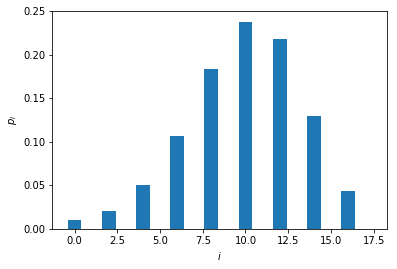

In [7]:
plt.bar(np.arange(cutoff),np.abs(psi)**2)
plt.xlabel("$i$")
plt.ylabel(r"$p_i$")
plt.show()

We can now plot the Wigner function of the heralded state,

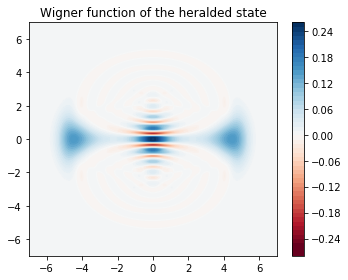

In [8]:
grid = 100
xvec = np.linspace(-7,7,grid)
Wp = wigner(Qobj(psi), xvec, xvec)
wmap = wigner_cmap(Wp)
sc1 = np.max(Wp)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
plt1 = axes.contourf(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.set_title("Wigner function of the heralded state");
cb1 = fig.colorbar(plt1, ax=axes)
fig.tight_layout()
plt.show()

and a cut of the Wigner function along $p=0$.

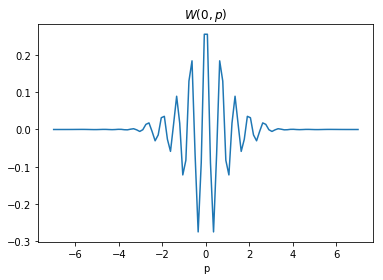

In [9]:
plt.plot(xvec, Wp[:,grid//2])
plt.title(r"$W(0,p)$")
plt.xlabel(r"p")
plt.show()

In [10]:
%reload_ext version_information
%version_information qutip, strawberryfields, thewalrus

Software versions
Python 3.6.8 64bit [GCC 7.3.0]
IPython 7.4.0
OS Linux 4.4.0 89 generic x86_64 with debian stretch sid
qutip 4.4.1
strawberryfields 0.10.0
thewalrus 0.11.0-dev
Fri Dec 27 22:40:40 2019 EST